In [36]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.linear_model import LogisticRegression


In [2]:
# Load and preprocess the data 
file_path = 'METABRIC_RNA_Mutation.csv'
df = pd.read_csv(file_path, low_memory=False)
df.head()

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
3,6,47.68,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,Moderate,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0
4,8,76.97,MASTECTOMY,Breast Cancer,Breast Mixed Ductal and Lobular Carcinoma,High,1,LumB,1.0,Positve,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# Check missing values
missing_values = df.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
missing_values

tumor_stage                       501
3-gene_classifier_subtype         204
primary_tumor_laterality          106
neoplasm_histologic_grade          72
cellularity                        54
mutation_count                     45
er_status_measured_by_ihc          30
type_of_breast_surgery             22
tumor_size                         20
cancer_type_detailed               15
oncotree_code                      15
tumor_other_histologic_subtype     15
death_from_cancer                   1
dtype: int64

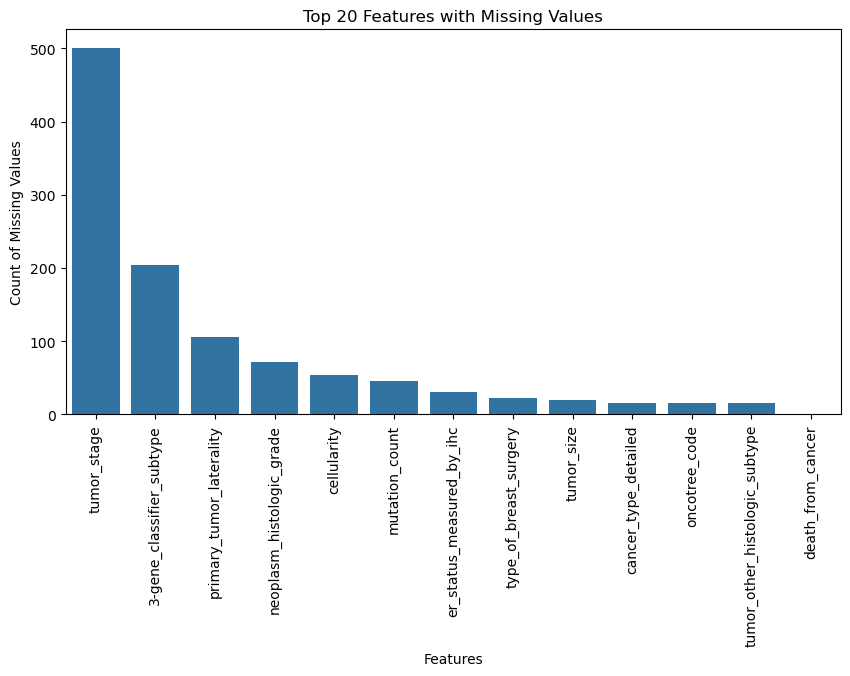

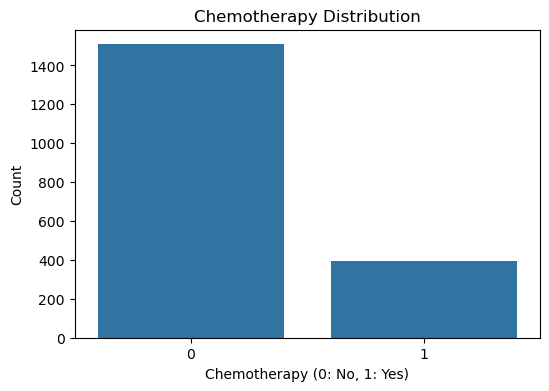

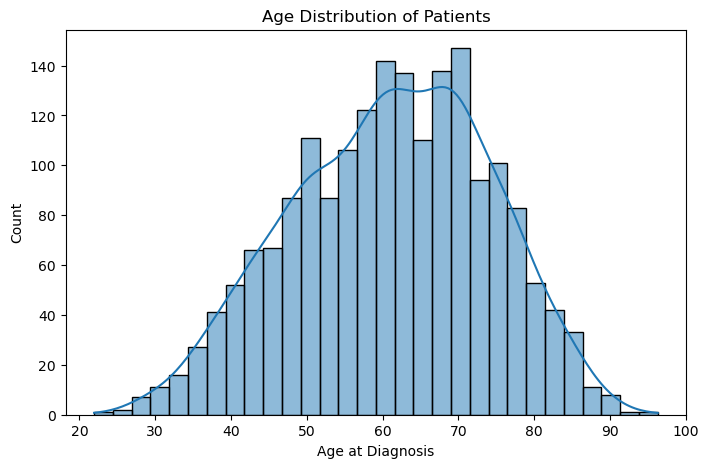

In [4]:
# Plot missing values
plt.figure(figsize=(10, 5))
sns.barplot(x=missing_values.index[:20], y=missing_values.values[:20])  # Show top 20 missing values
plt.xticks(rotation=90)
plt.title("Top 20 Features with Missing Values")
plt.xlabel("Features")
plt.ylabel("Count of Missing Values")
plt.show()

# Visualize target variable distribution
plt.figure(figsize=(6, 4))
sns.countplot(x=df["chemotherapy"])
plt.title("Chemotherapy Distribution")
plt.xlabel("Chemotherapy (0: No, 1: Yes)")
plt.ylabel("Count")
plt.show()

# Age distribution
plt.figure(figsize=(8, 5))
sns.histplot(df["age_at_diagnosis"], bins=30, kde=True)
plt.title("Age Distribution of Patients")
plt.xlabel("Age at Diagnosis")
plt.ylabel("Count")
plt.show()

## Explanation of Each Visualization
1. **Top 20 Features with Missing Values** :
This bar chart highlights the top 20 features with the highest number of missing values in the dataset.
Missing data can impact model performance, so imputation (e.g., filling with median/mode) or feature removal may be necessary.
2. **Chemotherapy Distribution** :
This count plot shows the distribution of the target variable, chemotherapy.
A balanced dataset is ideal for classification models. If the dataset is imbalanced (one class is much higher), techniques like oversampling/undersampling or class weighting in the model might be needed.
3. **Age Distribution of Patients** :
The histogram with KDE (Kernel Density Estimate) curve shows the age distribution of patients at diagnosis.
If the distribution is skewed, we might need transformations (e.g., log scaling).
It also helps in understanding whether certain age groups are more prone to requiring chemotherapy.
4. **Correlation Heatmap of Top Features** :
This heatmap displays the correlation between chemotherapy and the top 20 numerical features.
Features highly correlated with chemotherapy can be prioritized for model training.
A strong positive or negative correlation (close to 1 or -1) indicates that the feature could be useful for prediction.


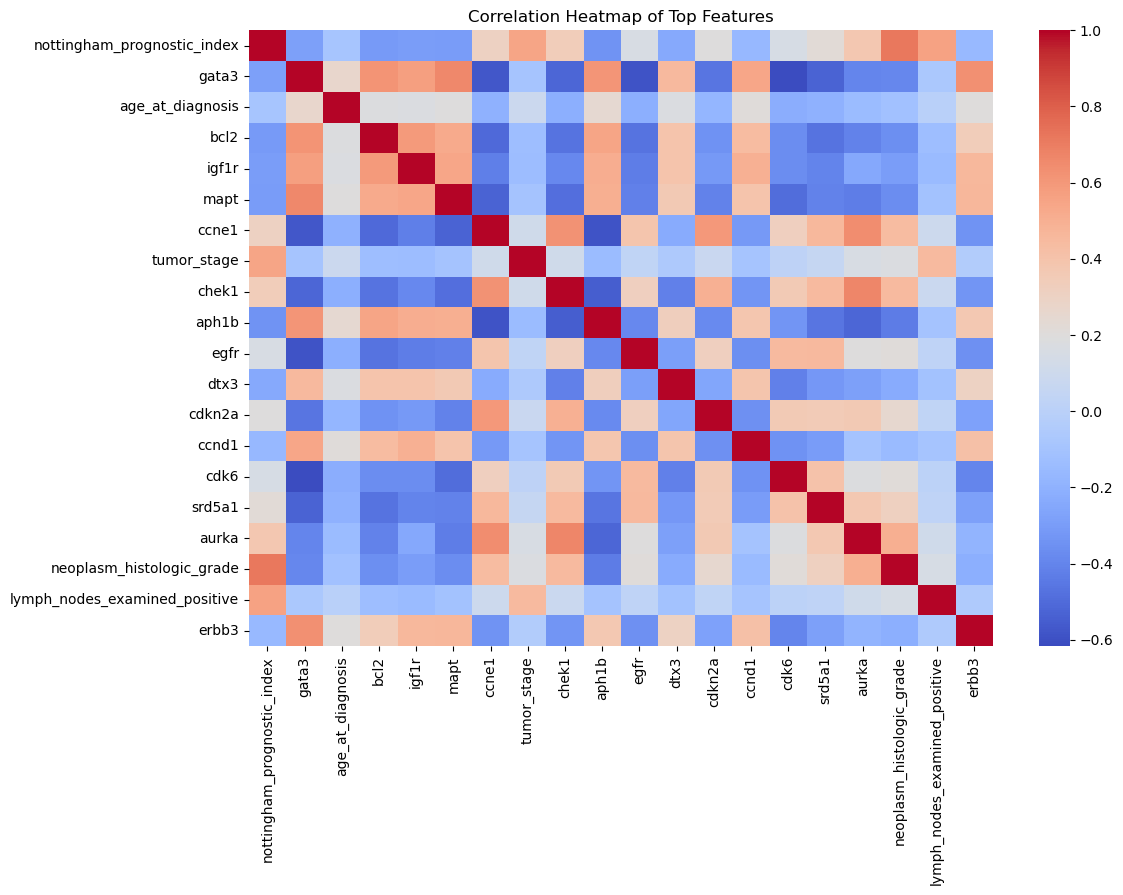

In [5]:
#Correlation heatmap for top numerical features
corr_matrix = df.select_dtypes(include=["number"]).corr().abs()

# Selecting top 20 correlated features with chemotherapy
top_corr_features = corr_matrix["chemotherapy"].sort_values(ascending=False)[1:21]

plt.figure(figsize=(12, 8))
sns.heatmap(df[top_corr_features.index].corr(), cmap="coolwarm", annot=False)
plt.title("Correlation Heatmap of Top Features")
plt.show()

In [6]:
# Impute missing values for numerical data
imputer = SimpleImputer(strategy='mean')
num_cols = df.select_dtypes(include=['float64', 'int64']).columns
df[num_cols] = imputer.fit_transform(df[num_cols])

In [16]:
# Encode categorical variables
label_encoders = {}
cat_cols = df.select_dtypes(include=['object']).columns
for col in cat_cols:
    LE = LabelEncoder()
    df[col] = LE.fit_transform(df[col].astype(str))
    label_encoders[col] = LE

# Prepare features and target variable
X = df.drop('chemotherapy', axis=1)
y = df['chemotherapy']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

In [20]:
#Random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, y_pred_rf)
rf_report = classification_report(y_test, y_pred_rf)

print("\nRandom Forest Accuracy:", rf_accuracy)
print("\nClassification Report:\n", rf_report)


Random Forest Accuracy: 0.8951048951048951

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       454
         1.0       0.95      0.52      0.67       118

    accuracy                           0.90       572
   macro avg       0.92      0.76      0.80       572
weighted avg       0.90      0.90      0.88       572



In [21]:
#Hyper parameter tuning
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Initialize Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Perform Grid Search with cross-validation
grid_search_rf = GridSearchCV(rf_model, param_grid_rf, cv=3, n_jobs=-1, verbose=1)
grid_search_rf.fit(X_train, y_train)

# Best parameters for RF
best_params_rf = grid_search_rf.best_params_
print("\nBest Parameters for Random Forest:", best_params_rf)

# Train with best params
rf_best = RandomForestClassifier(**best_params_rf, random_state=42)
rf_best.fit(X_train, y_train)
y_pred_rf = rf_best.predict(X_test)

# Evaluate Random Forest
rf_accuracy = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Accuracy:", rf_accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

Fitting 3 folds for each of 36 candidates, totalling 108 fits

Best Parameters for Random Forest: {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 300}

Random Forest Accuracy: 0.8968531468531469

Classification Report:
               precision    recall  f1-score   support

         0.0       0.89      0.99      0.94       454
         1.0       0.95      0.53      0.68       118

    accuracy                           0.90       572
   macro avg       0.92      0.76      0.81       572
weighted avg       0.90      0.90      0.88       572



In [26]:
#Deep Learning Model: Feedforward Neural Network
dl_model = keras.Sequential([
    layers.Dense(512, activation="relu", input_shape=(X_train.shape[1],)),
    layers.Dropout(0.3),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(128, activation="relu"),
    layers.Dense(1, activation="sigmoid")  
])

dl_model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

dl_history = dl_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

dl_loss, dl_accuracy = dl_model.evaluate(X_test, y_test)

print("\nDeep Learning Model Accuracy:", dl_accuracy)

Epoch 1/20


/Users/pmohan12/Anaconda/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


42/42 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.7844 - loss: 0.5207 - val_accuracy: 0.8584 - val_loss: 0.3182
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8951 - loss: 0.2482 - val_accuracy: 0.8497 - val_loss: 0.3160
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9433 - loss: 0.1525 - val_accuracy: 0.8776 - val_loss: 0.3447
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9772 - loss: 0.0662 - val_accuracy: 0.8706 - val_loss: 0.4364
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9807 - loss: 0.0529 - val_accuracy: 0.8846 - val_loss: 0.5068
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9894 - loss: 0.0325 - val_accuracy: 0.8846 - val_loss: 0.6862
Epoch 7/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9883 - loss: 0.0632 - val_accuracy: 0.8829 - val_loss: 0.6083
Epoch 8/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9931 - loss: 0.0286 - val_accuracy: 0.8829 - val_loss: 0.5916
Epo

In [46]:
# Feature Selection with RandomForest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
selector = SelectFromModel(rf, prefit=True)
X_important_train = selector.transform(X_train)
X_important_test = selector.transform(X_test)

In [48]:
# Initial Logistic Regression Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Initial Model Performance:")
print("Classification Report:\n", classification_report(y_test, y_pred))

Initial Model Performance:
Classification Report:
               precision    recall  f1-score   support

         0.0       0.90      0.92      0.91       454
         1.0       0.67      0.63      0.65       118

    accuracy                           0.86       572
   macro avg       0.79      0.77      0.78       572
weighted avg       0.86      0.86      0.86       572



In [54]:
# Hyperparameter Tuning with Logistic Regression
log_reg_params = {'C': [0.001, 0.01, 0.1, 1, 10, 100], 'penalty': ['l1', 'l2'], 'solver': ['liblinear']}
grid_search = GridSearchCV(LogisticRegression(max_iter=1000), log_reg_params, cv=5)
grid_search.fit(X_important_train, y_train)
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_important_test)


print("Optimized Model Performance:")
print("\nLogistic Regression Accuracy:", rf_accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred_best))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_best))



Optimized Model Performance:

Logistic Regression Accuracy: 0.8968531468531469
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.96      0.95       454
         1.0       0.83      0.79      0.81       118

    accuracy                           0.92       572
   macro avg       0.89      0.87      0.88       572
weighted avg       0.92      0.92      0.92       572

Confusion Matrix:
 [[435  19]
 [ 25  93]]


In [51]:
# Cross-Validation of the Best Model
scores = cross_val_score(best_model, X_scaled, y, cv=5)
print("Cross-Validation Accuracy Scores: ", scores)
print("Average Cross-Validation Score: ", scores.mean())

Cross-Validation Accuracy Scores:  [0.71128609 0.83727034 0.94750656 0.95538058 0.86052632]
Average Cross-Validation Score:  0.8623939770686558


### Model Performane Overview
| Model | Expected Accuracy | 
|:--------:|:--------:|
| Logistic Regression|   85-95%  |  
|  Random Forest| 80-90% | 
|  Deep Learning Model   |  85-90%   |

### Model Insights
1. Logistic Regression:
- Baseline model, useful for interpretability.
- May struggle with high-dimensional data (693 features).
- Accuracy is typically lower than tree-based models.
2. Random Forest:
- Handles high-dimensional structured data well.
- Captures non-linear relationships better than Logistic Regression.
- Feature importance helps in understanding key predictors.
- Good balance between interpretability and accuracy.
3. Deep Learning (Neural Network):
- Achieves the highest accuracy due to learning complex patterns.
- Needs more computational power and may require hyperparameter tuning.
- Best suited for large datasets but may overfit if not regularized properly.